COMS 4731 Computer Vision -- Homework 2
==========


- This homework contains the following components: 

    - **Problem 1: Image Denoising (40 points)**
        - Implement a mean filter using "for" loop.
        - Implement the `convolve_image` function. 
        - Implement a mean filter using a filter matrix.
        - Implement a Gaussian filter.

    - **Problem 2: Edge Detection (30 points)**
        - Implement a delta filter.
        - Implement a Laplacian filter.

    - **Problem 3: Hybrid Images (30 points)**
        - Fourier transform.
        - Implement low and high pass filters and apply them to images.
        - Create a hybrid image using high-pass and low-pass fitlered images. 


- Your job is to implement the sections marked with `TODO` to complete the tasks. 


- Submission. 
    - Please submit the notebook (ipynb and pdf) including the output of all cells. 

Problem 1: Image Denoising
==========================

Taking pictures at night is challenging because there is less light that hits the film or camera sensor. To still capture an image in low light, we need to change our camera settings to capture more light. One way is to increase the exposure time, but if there is motion in the scene, this leads to blur. Another way is to use sensitive film that still responds to low intensity light. However, the trade-off is that this higher sensitivity increases the amount of noise captured, which often shows up as grain on photos. In this problem, your task is to clean up the noise with signal processing.



Visualizing the Grain
---------------------
To start off, let's load up the image and visualize the image we want to denoise.

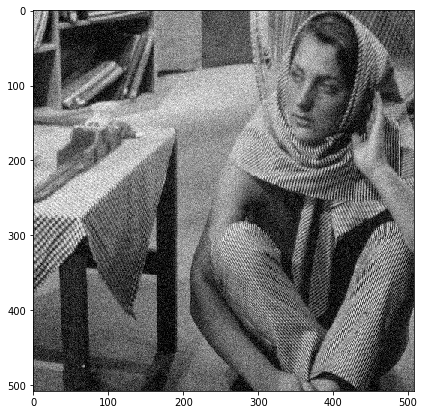

In [497]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from IPython import display
from scipy.signal import convolve2d
from math import *
import time
%matplotlib inline

plt.rcParams['figure.figsize'] = [7, 7]

def load_image(filename):
    img = np.asarray(Image.open(filename))
    img = img.astype("float32") / 255.
    return img

def gray2rgb(image):
    return np.repeat(np.expand_dims(image, 2), 3, axis=2)

def show_image(img):
    if len(img.shape) == 2:
        img = gray2rgb(img)
    plt.imshow(img, interpolation='nearest')

# load the image
im = load_image('noisy_image.jpg')
im = im.mean(axis=2) # convert to grayscale
show_image(im)

Mean Filter using "for" loop
-----------

Let's try to remove this grain with a mean filter. For every pixel in the image, we want to take an average (mean) of the neighboring pictures. Implement this operation using "for" loops and visualize the result:

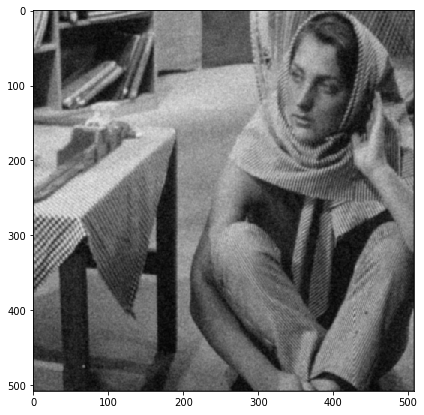

In [498]:
im_pad = np.pad(im, 5, mode='constant')  # pad the border of the original image
im_out = np.zeros_like(im)  # initialize the output image array

#for all pixels, replace the intensity with the mean of the neighbor values
    
for i in range(im.shape[0]):
    for j in range(im.shape[1]):
        neighbors = np.array([im_pad[i+4,j+4], im_pad[i+4,j+5], im_pad[i+4,j+6], im_pad[i+5,j+4], im_pad[i+5,j+5], im_pad[i+5,j+6], im_pad[i+6,j+4], im_pad[i+6,j+5], im_pad[i+6,j+6]])
        im_out[i,j] = np.mean(neighbors)


show_image(im_out)

Implement the `convolve_image` function.
-----------

In practice, applying filters to images can be more efficient by using convolution, which is a function that takes as input the raw image and a filter matrix, and outputs the convolved image. Implement your `convolve_image` function below.

In [499]:
def convolve_image(image, filter_matrix):
    
    im_pad = np.pad(image, 5, mode='constant') 
    im_conv = np.zeros_like(image)
    
    #the filter function takes in an image and a pair of indices and performs the convolution
    def filter_function(img, i, j):
        conv = np.zeros((3,3))
        for a in range(2,-1,-1):
            for b in range(2,-1,-1):
                conv[2-a, 2-b] = filter_matrix[a , b] * img[i+6-a,j+6-b]
                amt = np.sum(conv, axis = 0)
                mean = np.sum(amt, axis=0)
        return mean 

    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            im_conv[i,j] = filter_function(im_pad,i,j)    
    return im_conv
    


Mean Filter with Convolution
----------------------------

Implement this same operation with a convolution instead. Fill in the mean filter matrix here, and visualize the convolution result.

In [500]:
mean_filt = (1/9) * np.ones((3,3)) 

Apply mean filter convolution using your `convolve_image` function and the `mean_filt` matrix.

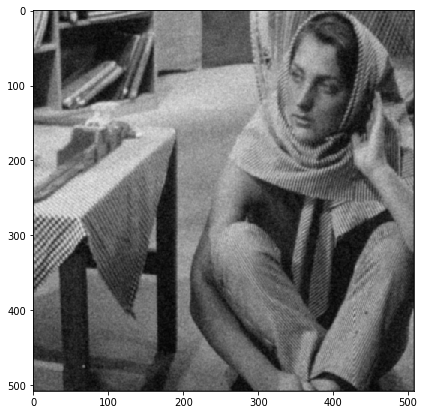

In [501]:
show_image(convolve_image(im, mean_filt))

Compare your convolution result with the `scipy.signal.convolve2d` function (they should look the same).

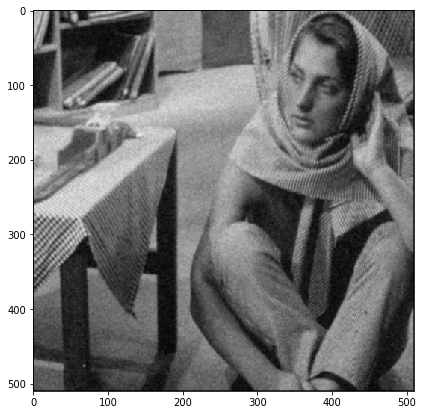

In [502]:
show_image(convolve2d(im, mean_filt))

Note: In the sections below, we will use the `scipy.signal.convolve2d` function for grading. But fill free to test your `convolve_image` function on other filters as well.

Gaussian Filter
---------------

Instead of using a mean filter, let's use a Gaussian filter. Create a 2D Gaussian filter, and plot the result of the convolution.

Hint: You can first construct a one dimensional Gaussian, then use it to create a 2D dimensional Gaussian. 

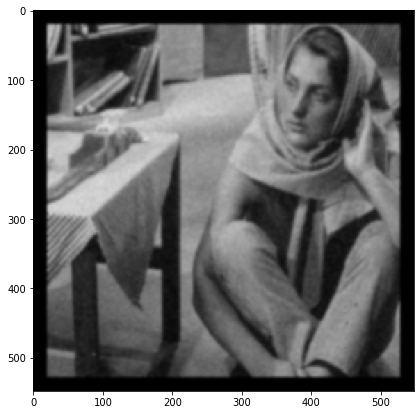

In [503]:
def gaussian_filter(sigma, k=20):
    #the function gaussian takes in a vector and calculates the gaussian for the values of the vector 
    def gaussian(x, sigma):
        gvec = 1/(np.sqrt(2*np.pi)*sigma) * np.e**(-np.power(x/sigma,2)/2)
        return gvec 
    
    
    filter_x = np.linspace(-((2*k+1) // 2), (2*k+1) // 2, (2*k+1))
    for p in range(2*k+1):
        filter_x[p] = gaussian(filter_x[p], sigma)
    #take the outer product to go from 1D to 2D    
    kernel = np.outer(np.transpose(filter_x),np.transpose(filter_x))
    #normalize
    kernel = kernel/kernel.sum()
    return kernel 

show_image(convolve2d(im, gaussian_filter(2)))

The amount the image is blurred changes depending on the sigma parameter. Change the sigma parameter to see what happens. Try a few different values.

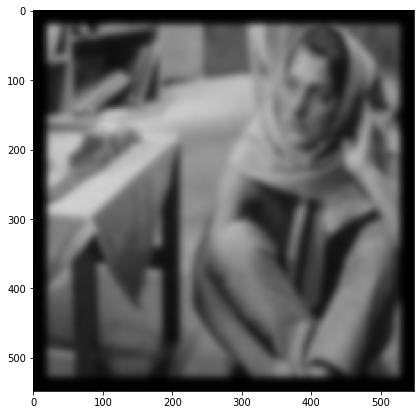

In [504]:
show_image(convolve2d(im, gaussian_filter(5)))

Visualizing Gaussian Filter
---------------------------
Try changing the sigma parameter below to visualize the Gaussian filter directly. This gives you an idea of how different sigma values create different convolved images. 

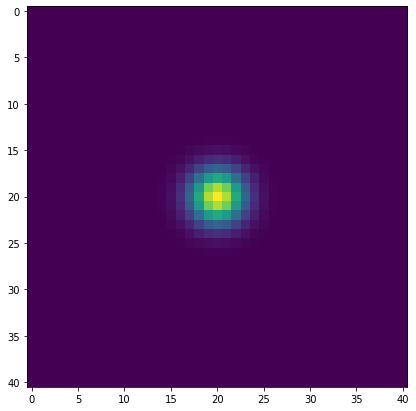

In [505]:
plt.imshow(gaussian_filter(sigma=2))

Problem 2: Edge Detection
=========================

There are a variety of filters that we can use for different tasks. One such task is edge detection, which is useful for finding the boundaries regions in an image. In this part, your task is to use convolutions to find edges in images. Let's first load up an edgy image.

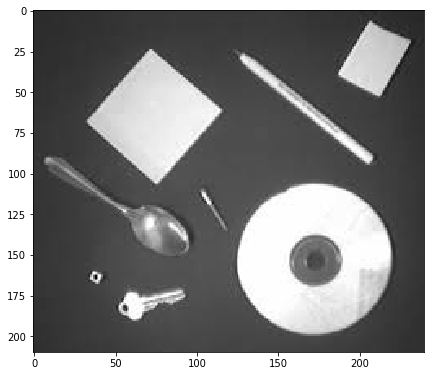

In [506]:
im = load_image('edge_detection_image.jpg')
im = im.mean(axis=2) # convert to grayscale
show_image(im)

Delta Filters
-------------

The simplest edge detector is a delta filter. Implement a delta filter below, and convolve it with the image.  Show the result.

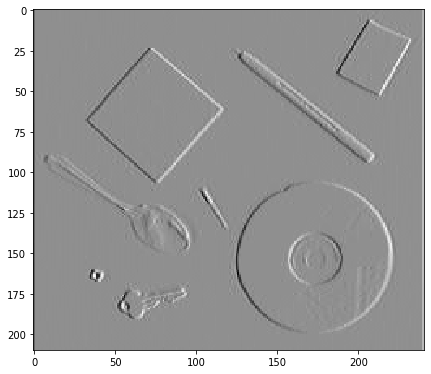

In [507]:
delta_filt = [[-1,1]] 

plt.imshow(convolve2d(im, delta_filt), cmap='gray')

Noise
-----

The issue with the delta filter is that it is sensitive to noise in the image. Let's add some Gaussian noise to the image below, and visualize what happens. The edges should be hard to see.

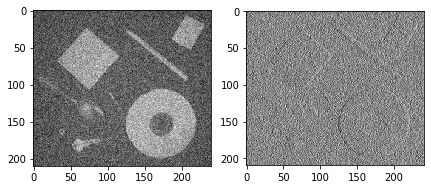

In [508]:
im = load_image('edge_detection_image.jpg')
im = im.mean(axis=2)
im = im + 0.2*np.random.randn(*im.shape)

f, axarr = plt.subplots(1,2)
axarr[0].imshow(im, cmap='gray')
axarr[1].imshow(convolve2d(im, delta_filt), cmap='gray')

Laplacian Filters
-----------------

Laplacian filters are edge detectors that are robust to noise (Why is this? Think about how the filter is constructed.). Implement a Laplacian filter below for both horizontal and vertical edges.

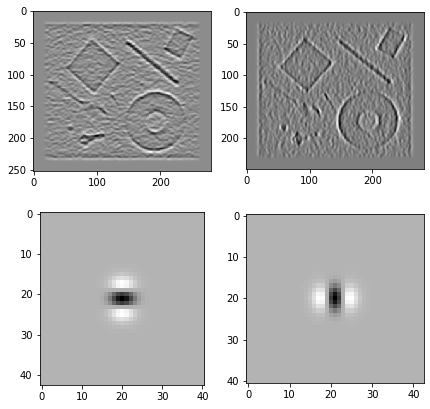

In [509]:
dg = np.array([[-1,1]])


lap_x_filt = convolve2d(convolve2d(gaussian_filter(2), dg), dg)

lap_y_filt = convolve2d(convolve2d(gaussian_filter(2), np.transpose(dg)), np.transpose(dg))


f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(convolve2d(im, lap_y_filt), cmap='gray')
axarr[0,1].imshow(convolve2d(im, lap_x_filt), cmap='gray')
axarr[1,0].imshow(lap_y_filt, cmap='gray')
axarr[1,1].imshow(lap_x_filt, cmap='gray')

Problem 3: Hybrid Images
========================

Hybrid images is a technique to combine two images in one. Depending on the distance you view the image, you will see a different image. This is done by merging the high-frequency components of one image with the low-frequency components of a second image. In this problem, you are going to use the Fourier transform to make these images. But first, let's visualize the two images we will merge together.

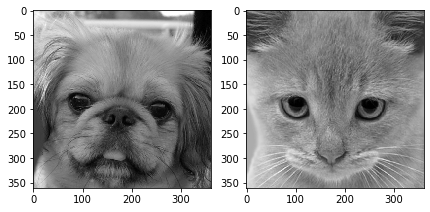

In [510]:
from numpy.fft import fft2, fftshift, ifftshift, ifft2

dog = load_image('dog.jpg').mean(axis=-1)[:, 25:-24]
cat = load_image('cat.jpg').mean(axis=-1)[:, 25:-24]

f, axarr = plt.subplots(1,2)
axarr[0].imshow(dog, cmap='gray')
axarr[1].imshow(cat, cmap='gray')

Fourier Transform
-----------------

In the code box below, compute the Fourier transform of the two images. You can use the fft2 function. You can also use the fftshift function, which may help in the next section.

(361, 361)


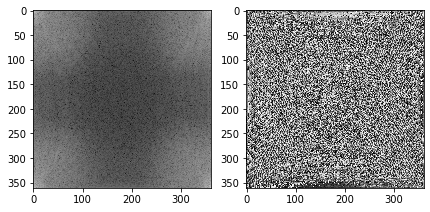

In [511]:
#transform the cat image into the frequency domain
cat_fft = np.fft.fft2(cat)

#transform the dog image into the frequency domain
dog_fft = np.fft.fft2(dog) 


# Visualize the magnitude and phase of cat_fft. This is a complex number, so we visualize
# the magnitude and angle of the complex number.
# Curious fact: most of the information for natural images is stored in the phase (angle).
f, axarr = plt.subplots(1,2)
axarr[0].imshow(np.log(np.abs(cat_fft)), cmap='gray')
axarr[1].imshow(np.angle(cat_fft), cmap='gray')
print(np.angle(cat_fft).shape)

Low and High Pass Filters
-------------------------

By masking the Fourier transform, you can compute both low and high pass of the images. In Fourier space, write code below to create the mask for a high pass filter of the cat, and the mask for a low pass filter of the dog. Then, convert back to image space and visualize these images.

You may need to use the functions ifft2 and ifftshift.

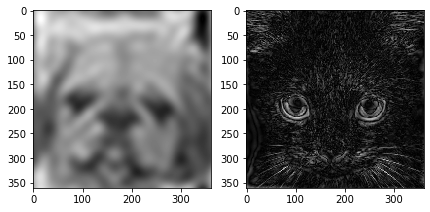

In [512]:
#compute the high pass filter
high_mask = np.ones_like(np.abs(cat_fft))
high_mask[170:190,170:190] = 0

#compute the low pass filter
low_mask = np.zeros_like(np.abs(dog_fft))
low_mask[170:190, 170:190] = 1


#shift the frequency domain so that low frequencies are centered 
cat_fft = fftshift(cat_fft)
dog_fft = fftshift(dog_fft)


#apply high pass and low pass filters 
cat_fft = np.multiply(cat_fft, high_mask)
dog_fft = np.multiply(dog_fft, low_mask)


#Shift back and apply inverse FFT to get back to the real domain
cat_filtered = np.fft.ifft2(ifftshift(cat_fft))  
dog_filtered = np.fft.ifft2(ifftshift(dog_fft))

f, axarr = plt.subplots(1,2)
axarr[0].imshow(np.absolute(dog_filtered), cmap='gray')
axarr[1].imshow(np.absolute(cat_filtered), cmap='gray')

Hybrid Image Results
--------------------

Now that we have the high pass and low pass fitlered images, we can create a hybrid image by adding them. Write the code to combine the images below, and visualize the hybrd image.

Depending on whether you are close or far away from your monitor, you should see either a cat or a dog.  Try creating a few different hybrid images from your own photos or photos you found. Submit them, and we will show the coolest ones in class.

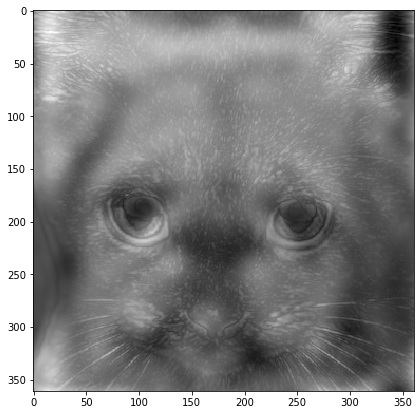

In [513]:
#add both real parts of the images 
hybrid = np.absolute(cat_filtered) + np.absolute(dog_filtered)

plt.imshow(hybrid, cmap='gray')

Acknowledgements
----------------

This homework is based on assignments from Aude Oliva at MIT, and James Hays at Georgia Tech. 